# Capstone Symposium: VAE Demo

In [20]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import DotsSymposium as sym
from ipywidgets import interact

torch.manual_seed(1234) #consistent results
device = 'cpu'

In [21]:
### Paths ###
work_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
art_json = os.path.join(work_dir, 'Datateam/Artificial_imset/artificial_kymographs.json')
exp_json = os.path.join(work_dir, 'Datateam/imset1/experimental_kymograph.json')
models_folder = os.path.join(work_dir, 'DotsTorch/Trained_models/')

In [22]:
# Custom dataset classes
class ArtKymoDataset(Dataset):
     def __init__(self):
         # Data loading
         with open(art_json, 'r') as f:
             kymos = np.asarray(json.loads(f.read())["kymoset"])

         # Mean centering to match artificial data
         for i, kymo in enumerate(kymos):
             kymos[i] = (kymo - np.mean(kymo)) / np.std(kymo)

         smaller_extreme = np.min([np.abs(kymos.min()), np.abs(kymos.max())])
         kymos = np.clip(kymos, -smaller_extreme, smaller_extreme)
         kymos = kymos.astype('float32')

         kymos = torch.from_numpy(kymos)
         self.x = kymos
         self.x = self.x[:,None,:,:]
         self.n_samples = kymos.shape[0]

     def __getitem__(self, index):
         return self.x[index,:,:]

     def __len__(self):
         return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))

        smaller_extreme = np.min([np.abs(kymos.min()), np.abs(kymos.max())])
        kymos = np.clip(kymos, -smaller_extreme, smaller_extreme)

        self.x = torch.from_numpy(kymos.astype('float32'))
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return torch.unsqueeze(self.x[:,:,index], 0)

    def __len__(self):
        return self.n_samples

    def numpy(self):
        return self.x.numpy()

class ComboDataset(Dataset):
    def __init__(self):
        with open(art_json, 'r') as f:
            ARTkymos = np.asarray(json.loads(f.read())["kymoset"])
        with open(exp_json, 'r') as f:
            EXPkymos = np.asarray(json.loads(f.read()))

        #ART processing
        for i, kymo in enumerate(ARTkymos):
            ARTkymos[i] = (kymo - np.mean(kymo)) / np.std(kymo)
        smaller_extreme = np.min([np.abs(ARTkymos.min()), np.abs(ARTkymos.max())])
        ARTkymos = np.clip(ARTkymos, -smaller_extreme, smaller_extreme)
        ARTkymos = ARTkymos.astype('float32')
        ARTkymos = torch.from_numpy(ARTkymos)
        ARTkymos = torch.squeeze(ARTkymos)
        ARTkymos = torch.transpose(ARTkymos, 0, 2)
        ARTkymos = torch.transpose(ARTkymos, 0, 1)
        
        #EXP processing
        smaller_extreme = np.min([np.abs(EXPkymos.min()), np.abs(EXPkymos.max())])
        EXPkymos = np.clip(EXPkymos, -smaller_extreme, smaller_extreme)
        EXPkymos = EXPkymos.astype('float32')
        #EXPkymos = np.transpose(EXPkymos, (2,0,1))
        EXPkymos = torch.from_numpy(EXPkymos)
        
        kymos = torch.cat((ARTkymos, EXPkymos), dim=2)
        #print(kymos.size())

        self.x = kymos
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return torch.unsqueeze(self.x[:,:,index], 0)

    def __len__(self):
        return self.n_samples

    def numpy(self):
        return self.x.numpy()

In [23]:
# Use custom dataloader functions to construct artificial, experimental, and combined datasets
dataset = ComboDataset()
expset = ExpKymoDataset()
artset = ArtKymoDataset()

In [24]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, mu, logsigma, decoder):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.mu = mu
        self.logsigma = logsigma
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

    def forward(self, x):
        h = self.encoder(x)
        mu, logsigma = self.mu(h), self.logsigma(h)

        # resample
        z = mu + torch.exp(logsigma) * torch.randn(mu.shape)

        return mu, logsigma, self.decoder(z)

    def embed(self, x):
        with torch.inference_mode():
            return self.mu(self.encoder(x))

    def loss(self, x, beta = 1):
        mu, logsigma, x_hat = self.forward(x)
        recon = self.mse_loss(x_hat, x)
        kl = torch.mean(0.5 * torch.sum(mu**2 + torch.exp(logsigma)**2 - 2 * logsigma - 1, dim=1))

        return recon + (beta * kl)

In [25]:
def train(dataloader, model, optimizer, beta = 1, device = 'cpu', report_interval = 50):
    """
    Adapted from https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters
    """
    size = len(dataloader.dataset)
    model.to(torch.device(device))
    model.train()

    for batch, X in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        loss = model.loss(X, beta=beta)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if report_interval is not None and batch % report_interval == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [26]:
model = VariationalAutoencoder(
    nn.Sequential(
        nn.Conv2d(1, 8, (3, 3), padding='same'),           # N x 8 x 20 x 60
        nn.Tanh(),
        nn.Conv2d(8, 8, (3, 3), stride=2, padding = 1),    # N x 8 x 10 x 30
        nn.Tanh(),

        nn.Conv2d(8, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        nn.Tanh(),

        # nn.Conv2d(16, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        # nn.Tanh(),

        # nn.Conv2d(16, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        # nn.Tanh(),

        nn.Conv2d(16, 16, (3, 3), stride=2, padding = 1),  # N x 16 x 5 x 15
        nn.Tanh(),

        nn.Flatten()
    ),
    nn.Linear(1200, 2),  # mu
    nn.Linear(1200, 2),  # sigma
    nn.Sequential(
        nn.Linear(2, 1200),
        # nn.Unflatten(1, (1, 20, 60)),  # N x 1 x 20 x 60, let's be lazy
        # nn.Conv2d(1, 1, (3, 3), padding='same'),
        # nn.Conv2d(1, 1, (3, 3), padding='same'),
        # nn.ReLU()

        nn.Unflatten(1, (16, 5, 15)),

        # U-net style "up-conv"
        nn.Upsample(scale_factor=2, mode='bilinear'), # N x 16 x 10 x 30
        nn.Conv2d(16, 8, (3, 3), padding='same'),     # N x 8 x 20 x 30
        nn.Tanh(),

        # U-net style "up-conv"
        nn.Upsample(scale_factor=2, mode='bilinear'), # N x 8 x 20 x 60
        nn.Conv2d(8, 1, (3, 3), padding='same'),      # N x 1 x 20 x 60
        nn.Tanh(),
    )
)

In [27]:
# Training variables and hyperparameters
num_epoch = 200
losses = np.zeros(num_epoch)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loader = DataLoader(expset, batch_size=8, shuffle=True)

for epoch in tqdm(range(num_epoch)):
    train(loader, model, opt, beta=0.0001, device=device, report_interval=None)

    X_val = torch.permute(
        # sample 10 random examples to validate with
        dataset[torch.randint(len(dataset), size=(50,))],
        # reshape to [N, C, H, W]
        (3, 0, 1, 2)
    )

    with torch.inference_mode():
        losses[epoch] = loss = model.loss(X_val.to(device)).item()
else:
    save_model = True
    model_name = f'JC_model.{num_epoch}.pt'

    if save_model:
        torch.save(model.state_dict(), os.path.join(models_folder, model_name))

100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


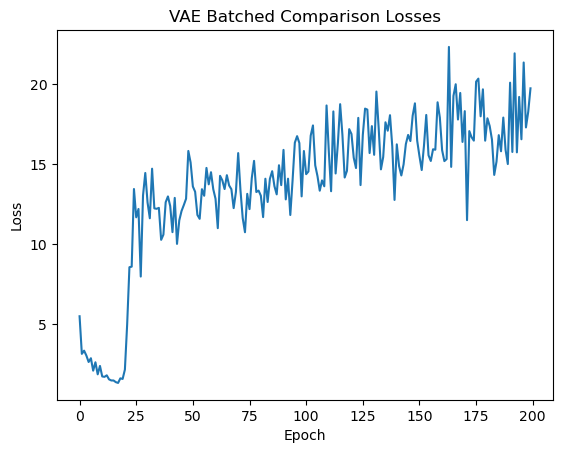

In [28]:
sym.plot_loss(losses)

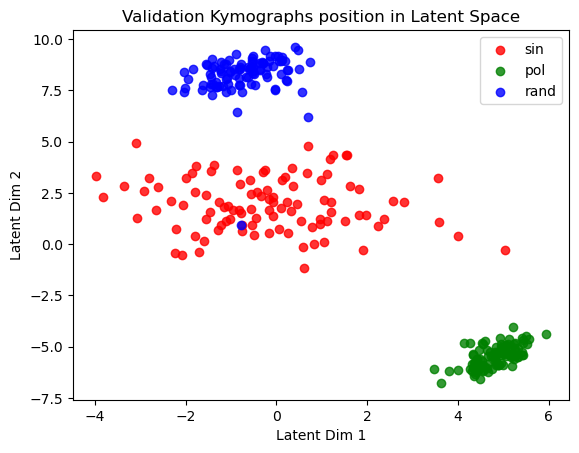

In [29]:
sym.plot_latent(model, dataset, exp = False)

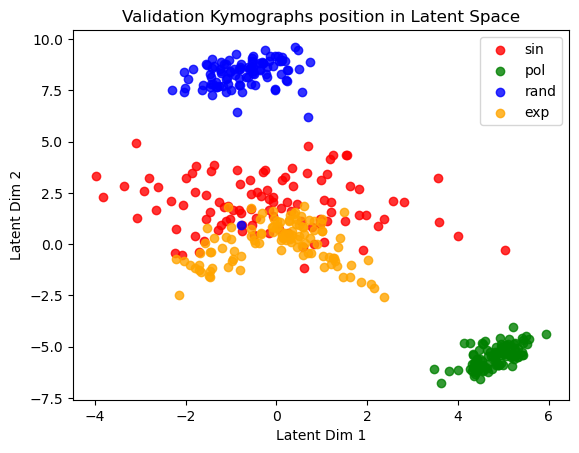

In [30]:
sym.plot_latent(model, dataset, exp = True)

ID: [64 34 68]


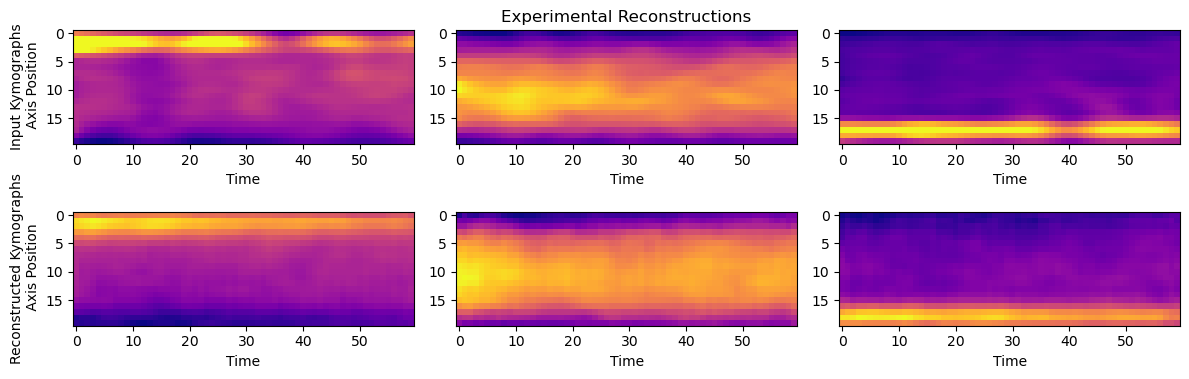

In [35]:
sym.plot_sample_im(model, expset)

In [37]:
@interact
def plot_reconstructed(D1_lower=(-6,6,3), D1_upper=(-3,9,3), D2_lower=(-11,13,4), D2_upper=(-8,12,4)):
    plt.figure(figsize=(15,15))
    h = 20
    w = 60
    hn = 24
    wn = 8
    img = np.ones((hn*h,wn*w))*-1
    for i, a in enumerate(np.linspace(D1_lower,D1_upper, num=hn)):
        for j, b in enumerate(np.linspace(D2_lower, D2_upper, num=wn)):
            z = torch.Tensor([[a,b]]).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(h, w).to('cpu').detach().numpy()
            img[20*i+1:20*i+19,60*j+1:60*j+59] = x_hat[1:19,1:59]
        
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.ylim(0,480)
    plt.xlim(0,480)
    plt.imshow(img, cmap='plasma')

interactive(children=(IntSlider(value=0, description='D1_lower', max=6, min=-6, step=3), IntSlider(value=3, de…